In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv

import duckdb

conn = duckdb.connect('mydb.db') # create an in-memory database

In [2]:
conn.sql("SHOW ALL TABLES")

┌──────────┬─────────┬─────────────┬───────────────────────────┬──────────────────────────────────────┬───────────┐
│ database │ schema  │    name     │       column_names        │             column_types             │ temporary │
│ varchar  │ varchar │   varchar   │         varchar[]         │              varchar[]               │  boolean  │
├──────────┼─────────┼─────────────┼───────────────────────────┼──────────────────────────────────────┼───────────┤
│ mydb     │ main    │ SI_VI_AD0   │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_AD1   │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_RPTR0 │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_RPTR1 │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ TBB         │ [Tiles, ADbc, RPTRbc]     │ [VARCHA

In [3]:
rptrmatch0 = conn.sql("SELECT * FROM SI_VI_RPTR0").df()
rptrmatch1 = conn.sql("SELECT * FROM SI_VI_RPTR1").df()
admatch0 = conn.sql("SELECT * FROM SI_VI_AD0").df()
admatch1 = conn.sql("SELECT * FROM SI_VI_AD1").df()

In [4]:
rptrmatch0

,index,BCs,TBB,Tiles
0,ACTTCTAAATAAGC,77342,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...
1,TGTGGGCATGTTAG,74370,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...
2,CTCAATCGACAATT,17211,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...
3,TTTAACGCATGAGT,8754,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...
4,ACTTCTAAAAAAGC,619,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...
...,...,...,...,...
174,TGGATAAATATAAT,1,GCTGATAGAATTTCTGAAAATTCTAAGATGATTAAGACTGAAATTT...,GCTGATAGAATTTCTGAAAATTCTAAGATGATTAAGACTGAAATTT...
175,AATATTATATAAGC,1,ATTCATGATTTGGATATGTCTCCAGCTTCTTCTTCTACTAATTTGG...,ATTCATGATTTGGATATGTCTCCAGCTTCTTCTTCTACTAATTTGG...
176,CTTGAAAAAAACGC,1,GCTGCTTTGCAGAATCAAAGAGTTGCTGCTATTATTCAATCTACTG...,GCTGCTTTGCAGAATCAAAGAGTTGCTGCTATTATTCAATCTACTG...
177,TGTTGTAACTAACA,1,ATGTCTGGTAGAGTTTCTTCTCCACCAGTTACTGTTCCACCAAGAG...,ATGTCTGGTAGAGTTTCTTCTCCACCAGTTACTGTTCCACCAAGAG...


In [5]:
r0_ads = []

for index, row in rptrmatch0.loc[:, ['TBB']].iterrows():
    try:
        #     print(row['TBB'])
        tbb_str = row['TBB']
        pad = tbb_str.split('-')[1]
#         print(t)
    except AttributeError:
        pad = 0 
    finally:
        r0_ads.append(pad)


rptrmatch0['Putative_AD'] = r0_ads

In [6]:
rptrmatch0

,index,BCs,TBB,Tiles,Putative_AD
0,ACTTCTAAATAAGC,77342,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...,TTTAGATTACA
1,TGTGGGCATGTTAG,74370,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...,GTATAATTCCA
2,CTCAATCGACAATT,17211,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...,GCCGACCCCTT
3,TTTAACGCATGAGT,8754,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,TTGCTCGCTCG
4,ACTTCTAAAAAAGC,619,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...,GAATCAATCGC
...,...,...,...,...,...
174,TGGATAAATATAAT,1,GCTGATAGAATTTCTGAAAATTCTAAGATGATTAAGACTGAAATTT...,GCTGATAGAATTTCTGAAAATTCTAAGATGATTAAGACTGAAATTT...,GAAGTTTGTAA
175,AATATTATATAAGC,1,ATTCATGATTTGGATATGTCTCCAGCTTCTTCTTCTACTAATTTGG...,ATTCATGATTTGGATATGTCTCCAGCTTCTTCTTCTACTAATTTGG...,ACTAAATAGGC
176,CTTGAAAAAAACGC,1,GCTGCTTTGCAGAATCAAAGAGTTGCTGCTATTATTCAATCTACTG...,GCTGCTTTGCAGAATCAAAGAGTTGCTGCTATTATTCAATCTACTG...,CAAACCGGGAC
177,TGTTGTAACTAACA,1,ATGTCTGGTAGAGTTTCTTCTCCACCAGTTACTGTTCCACCAAGAG...,ATGTCTGGTAGAGTTTCTTCTCCACCAGTTACTGTTCCACCAAGAG...,GCGGCCAAGGT


In [7]:
admatch0_tomerge = admatch0.rename({"index":'Putative_AD'}, axis=1)
admatch0_tomerge

,Putative_AD,BCs,TBB,Tiles
0,TACTTCATCAC,38470,GATGCATTTACTCCATTTGAAGGTGGTGCTTCTGTTACTAATGCAT...,GATGCATTTACTCCATTTGAAGGTGGTGCTTCTGTTACTAATGCAT...
1,TCTCTAACTGC,31440,TCTTCTACTGCTTTGCAAAGAAGAGGTCATCCATCTAGACCACCAG...,TCTTCTACTGCTTTGCAAAGAAGAGGTCATCCATCTAGACCACCAG...
2,TGGCGGGGAGG,30245,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...
3,AGGATCATCCA,20301,TCTTATCAAGTTAGACCAAGACAAGAACCATTGCCACCAATCTTTA...,TCTTATCAAGTTAGACCAAGACAAGAACCATTGCCACCAATCTTTA...
4,GTCCCCCTTAA,18131,TCTGGTACTGCTACTTCTCCACCAGCTCCAGCTGGTGGTGTTAGGA...,TCTGGTACTGCTACTTCTCCACCAGCTCCAGCTGGTGGTGTTAGGA...
...,...,...,...,...
2563,AAGACATTCGC,1,TCTTTGTTTCCAGAAGAAGAGAATAAATTGCATGAAGTTGCTCAAT...,TCTTTGTTTCCAGAAGAAGAGAATAAATTGCATGAAGTTGCTCAAT...
2564,TCTCTAACGGC,1,GGTTCTTTGATTGAATCTGCTTATAGAGCTGCTCCAACTGAAATGA...,GGTTCTTTGATTGAATCTGCTTATAGAGCTGCTCCAACTGAAATGA...
2565,CGATTTACTGC,1,GCTGGTGCTGAAGTTACTTCTAAACCATTGCAAGCTCCAGTTGATG...,GCTGGTGCTGAAGTTACTTCTAAACCATTGCAAGCTCCAGTTGATG...
2566,TTGATCTCGGA,1,ACTTCTCCATATTCTTTGTTTGATTCTCCATCTGAAGGTTATGAAA...,ACTTCTCCATATTCTTTGTTTGATTCTCCATCTGAAGGTTATGAAA...


In [9]:
ex0_merge = rptrmatch0.merge(admatch0_tomerge, how = 'inner', on='Tiles',
                            suffixes=('_RPTR', '_AD'))
ex0_merge = ex0_merge.fillna(0)
ex0_merge

,index,BCs_RPTR,TBB_RPTR,Tiles,Putative_AD_RPTR,Putative_AD_AD,BCs_AD,TBB_AD
0,TTTAACGCATGAGT,8754,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,TTGCTCGCTCG,TTCCCTAGGGG,4,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...
1,GAAACAGTAAATTC,7,TCTGTTGAAAATTCTCCAGAATTGAAATCTGATGAAGTTGATTCTG...,TCTGTTGAAAATTCTCCAGAATTGAAATCTGATGAAGTTGATTCTG...,AAGCTATGTAC,TACACTGGTCC,1,TCTGTTGAAAATTCTCCAGAATTGAAATCTGATGAAGTTGATTCTG...
2,AATTATAAAAACGC,7,GTTATTACTGATTCTCAATCTACTTGGTTGCCATCTTCTACTTCTT...,GTTATTACTGATTCTCAATCTACTTGGTTGCCATCTTCTACTTCTT...,GTGGATACTCC,GGACTAGTAAC,4,GTTATTACTGATTCTCAATCTACTTGGTTGCCATCTTCTACTTCTT...
3,TGGAGAAAGAAAAG,6,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,ACCTTTTCCAT,CGATATATTGC,9,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...
4,TGGAGAAAGAAAAG,6,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,ACCTTTTCCAT,CCCTAAACCAT,4,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...
5,TGGAGAAAGAAAAG,6,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,ACCTTTTCCAT,TGCTAGTGTCG,1,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...
6,TGGAGAATGTAAAT,5,CAATCTACTGGTCATTCTATTACTACTTCTGCTTTGACTAATAGAT...,CAATCTACTGGTCATTCTATTACTACTTCTGCTTTGACTAATAGAT...,ATTCTAATCAA,ACCATCATCCC,1,CAATCTACTGGTCATTCTATTACTACTTCTGCTTTGACTAATAGAT...
7,GACACACTAAATTC,3,GACTTTGACTTTGCTTTGCCACATACTGCTACTGTTTCTGATACTA...,GACTTTGACTTTGCTTTGCCACATACTGCTACTGTTTCTGATACTA...,AAAGGGGTGAT,GCCCCTCGTCG,2,GACTTTGACTTTGCTTTGCCACATACTGCTACTGTTTCTGATACTA...
8,CGTTCAAAATAAGC,2,TTGACTTCTCCATCTTTGTATAATGGTTCTCCAGACTTTGATTCAT...,TTGACTTCTCCATCTTTGTATAATGGTTCTCCAGACTTTGATTCAT...,TTAATGTCACT,ATGATACGCAC,1,TTGACTTCTCCATCTTTGTATAATGGTTCTCCAGACTTTGATTCAT...
9,TTTAACGCATGAGA,2,CAGAAACATACTTCTGTTGATAGAACTTTGCAACAAGATAGATTGG...,CAGAAACATACTTCTGTTGATAGAACTTTGCAACAAGATAGATTGG...,CGGATAAGACA,TTATAGATGTT,6,CAGAAACATACTTCTGTTGATAGAACTTTGCAACAAGATAGATTGG...


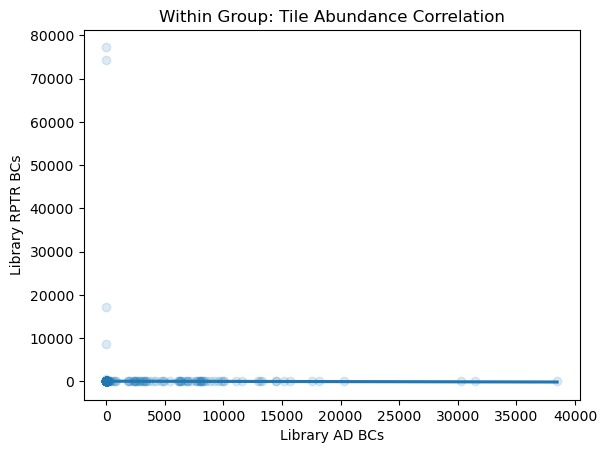

In [9]:
sns.regplot(x='BCs_AD', y='BCs_RPTR', data=ex0_merge, scatter_kws={'alpha':0.15})

plt.title('Within Group: Tile Abundance Correlation')
plt.xlabel('Library AD BCs')
plt.ylabel('Library RPTR BCs')
plt.show()

In [10]:
#rptrmatch1

r1_ads = []

for index, row in rptrmatch1.loc[:, ['TBB']].iterrows():
    try:
        #     print(row['TBB'])
        tbb_str = row['TBB']
        pad = tbb_str.split('-')[1]
#         print(t)
    except AttributeError:
        pad = 0 
    finally:
        r1_ads.append(pad)


rptrmatch1['Putative_AD'] = r1_ads

In [11]:
rptrmatch1

,index,BCs,TBB,Tiles,Putative_AD
0,TGTGGGCATGTTAG,140158,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...,GTATAATTCCA
1,ACTTCTAAATAAGC,139711,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...,TTTAGATTACA
2,CTCAATCGACAATT,29314,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...,GCCGACCCCTT
3,TTTAACGCATGAGT,15848,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,TTGCTCGCTCG
4,ACTTCTAAAAAAGC,1088,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...,GAATCAATCGC
...,...,...,...,...,...
234,ACTCCAAAAAACGC,1,CAAACTCCAAATATGGCTATGCAAGGTAAATTTCATGCTTTGATTC...,CAAACTCCAAATATGGCTATGCAAGGTAAATTTCATGCTTTGATTC...,GCCGGGATTGA
235,AGTAGAAAGAAAAT,1,TTTGATAAATTTACTTCTGCTGATTCTATGGGTCAACAAGAATTGT...,TTTGATAAATTTACTTCTGCTGATTCTATGGGTCAACAAGAATTGT...,AATGAAACTTA
236,CGGATTATTCAATT,1,GATTATTCTGGTTTGCAATCTGATTATTCTCCATTGACTGGTGTTC...,GATTATTCTGGTTTGCAATCTGATTATTCTCCATTGACTGGTGTTC...,GAGCGATCGCA
237,TGTGTGCAAGTTAG,1,GGTAATTATAATCAACACTTTGGTGCTGCTGGTATTATTTCTTCTC...,GGTAATTATAATCAACACTTTGGTGCTGCTGGTATTATTTCTTCTC...,AGGGAGACTGG


In [12]:
admatch1_tomerge = admatch1.rename({"index":'Putative_AD'}, axis=1)
admatch1_tomerge

,Putative_AD,BCs,TBB,Tiles
0,TGGCGGGGAGG,12676,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...
1,TACTTCATCAC,9198,GATGCATTTACTCCATTTGAAGGTGGTGCTTCTGTTACTAATGCAT...,GATGCATTTACTCCATTTGAAGGTGGTGCTTCTGTTACTAATGCAT...
2,TCTCTAACTGC,6087,TCTTCTACTGCTTTGCAAAGAAGAGGTCATCCATCTAGACCACCAG...,TCTTCTACTGCTTTGCAAAGAAGAGGTCATCCATCTAGACCACCAG...
3,AGGATCATCCA,5744,TCTTATCAAGTTAGACCAAGACAAGAACCATTGCCACCAATCTTTA...,TCTTATCAAGTTAGACCAAGACAAGAACCATTGCCACCAATCTTTA...
4,GTCCCCCTTAA,4173,TCTGGTACTGCTACTTCTCCACCAGCTCCAGCTGGTGGTGTTAGGA...,TCTGGTACTGCTACTTCTCCACCAGCTCCAGCTGGTGGTGTTAGGA...
...,...,...,...,...
840,GTGTAGGTGAG,1,CATTCTTCTGTTTCTGGTGTTAATTCTAGAAGAAGAGATAAACCAT...,CATTCTTCTGTTTCTGGTGTTAATTCTAGAAGAAGAGATAAACCAT...
841,CACGAGAAGTG,1,TCTGATGATTTGGAAGTTGTTGAACCAACTTCTGGTCATCAAAGAA...,TCTGATGATTTGGAAGTTGTTGAACCAACTTCTGGTCATCAAAGAA...
842,GTGCGGGGAGG,1,GATACTATTTCTGCTGCTACTACTTCTGCTTCTTCTCCAGATTTGA...,GATACTATTTCTGCTGCTACTACTTCTGCTTCTTCTCCAGATTTGA...
843,TTTCGCTGGGA,1,TTGCAAGAAGACTTTGTCTTGTATCCATCTCAACATCCAAGAGATT...,TTGCAAGAAGACTTTGTCTTGTATCCATCTCAACATCCAAGAGATT...


In [ ]:
ex1_merge = rptrmatch1.merge(admatch1_tomerge, how = 'inner', on='Putative_AD',
                            suffixes=('_RPTR', '_AD'))
ex1_merge = ex1_merge.fillna(0)
ex1_merge